## <center> Income Prediction </center>

The goal of the task is to build the model **Classification of Users**: the input of the model shall the data about a person and as as output shall be prediction of the person's binary income (more of less than $ 50.000 per year).

## <center> Libraries Import </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
from comet_ml import Experiment

In [3]:
experiment = Experiment(project_name = 'us-citizens-income-prediction-model',
                       workspace = 'nataliamantyk',
                       api_key = '2ZlKWCvoe3rTUNPPPRpjc8C19',
                       log_code = True)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/nataliakonovalova/Documents/SKILLFACTORY/ML-6_Selection and Assortment of features' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nataliamantyk/us-citizens-income-prediction-model/cf510b42ea4a4c1f8f4e7dcffd30fc96



In [4]:
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

## <center> Download Data </center>

In [ ]:
%%capture
!wget https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv
!wget https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv

In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0


In [6]:
# shape of the data-sets
train_data.shape, test_data.shape

((24420, 13), (8141, 13))

In [7]:
# target feature
target_name = 'income'

y_train = train_data[target_name]
y_test = test_data[target_name]

X_train = train_data.drop(columns = [target_name])
X_test = test_data.drop(columns = [target_name])

In [8]:
# assessing if data-set is balanced

y_train.value_counts(normalize = True)

income
0    0.757821
1    0.242179
Name: proportion, dtype: float64

### Conclusion:

The data-set is unbalanced, hence there is unbalanced binary classifier  

## <center> General Statistics of numerical features </center>

In [9]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=218784dd41b048b6a3de5e5870d8183c&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=218784dd41b048b6a3de5e5870d8183c&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'imageId': '218784dd41b048b6a3de5e5870d8183c'}

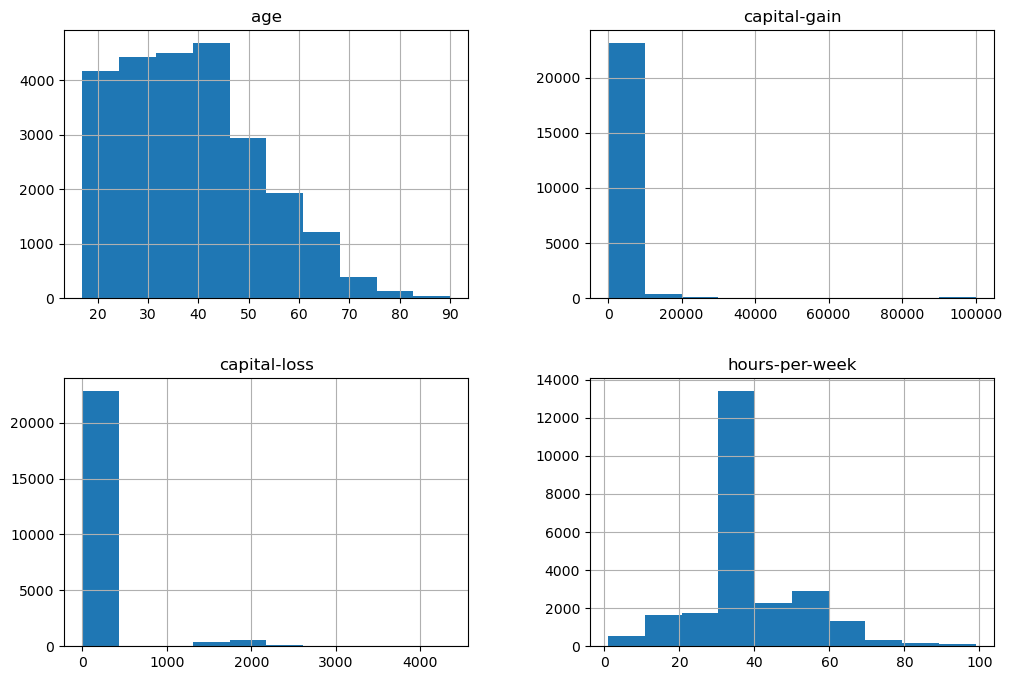

In [10]:
X_train.hist(figsize = (12, 8))
experiment.log_figure('X_train_numeric_distribution', plt)

### Conclusion:

The result is:

- There are only 4 numerical features in the data-set;

- User age ranges from 17 to 90 years, with an average of 39 years;

- There are gaps in the features 'capital-gain' & 'capital-loss' (the value of count of these features are smaller than others). It is clear seen that the majority of data is simply zeros.


## <center> Data Preprocessing </center>

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


### Processing gaps in data

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей.

Самые популярные методы для обработки пропусков:

- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);

- Заполнение средним/медианным значением;

- Заполненние самым частым значением;

- Заполнение случайным значением.


**Важно: тестовую выборку мы всегда обрабатываем также, как и обучающую выборку**.

In [12]:
X_train.isnull().sum()

age                  0
workclass         1197
education          977
marital-status       0
occupation           0
relationship         0
race                 0
sex                  0
capital-gain       715
capital-loss       484
hours-per-week       0
native-country       0
dtype: int64

In [13]:
X_test.isnull().sum()

age                 0
workclass         431
education         325
marital-status      0
occupation          0
relationship        0
race                0
sex                 0
capital-gain      262
capital-loss      167
hours-per-week      0
native-country      0
dtype: int64

In [14]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [15]:
print(X_train['workclass'].mode())
print(X_train['education'].mode())

0    Private
Name: workclass, dtype: object
0    HS-grad
Name: education, dtype: object


In [16]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Coding of categorical features

In [17]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 
               'native-country']

numerical = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

In [18]:
X_train[categorical].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


In [19]:
for column in categorical:
    print('Number of unique characteristics in the feature {}'. format(column), X_train[column].nunique())

Number of unique characteristics in the feature workclass 9
Number of unique characteristics in the feature education 16
Number of unique characteristics in the feature marital-status 7
Number of unique characteristics in the feature occupation 15
Number of unique characteristics in the feature relationship 6
Number of unique characteristics in the feature race 5
Number of unique characteristics in the feature sex 2
Number of unique characteristics in the feature native-country 42


### Label Encoding

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X_train_le = X_train.copy()
X_test_le = X_test.copy()

for feature in categorical:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


### One Hot Encoding

In [21]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()

X_train_onehot = onehot_encoder.fit_transform(X_train[categorical]).toarray()
X_test_onehot = onehot_encoder.transform(X_test[categorical]).toarray()

columns = onehot_encoder.get_feature_names_out(categorical)

X_train_onehot = pd.DataFrame(X_train_onehot, columns = columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns = columns)

X_train_oh = pd.concat([X_train, X_train_onehot], axis = 1)
X_test_oh = pd.concat([X_test, X_test_onehot], axis = 1)

X_train_oh = X_train_oh.drop(columns = categorical)
X_test_oh = X_test_oh.drop(columns = categorical)

X_train_oh.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_?,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,59,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## <center> Modeling </center>

In [22]:
from sklearn.linear_model import LogisticRegression

model_le = linear_model.LogisticRegression(random_state = 42, max_iter = 10000)
model_oh = linear_model.LogisticRegression(random_state = 42, max_iter = 10000)

model_le.fit(X_train_le, y_train)
model_oh.fit(X_train_oh, y_train)

LogisticRegression(max_iter=10000, random_state=42)

## <center> Validation of the model on a test sample </center>

In [23]:
prediction_le = model_le.predict(X_test_le)
prediction_oh = model_oh.predict(X_test_oh)

In [24]:
np.unique(prediction_le)

array([0, 1])

In [25]:
np.unique(prediction_oh)

array([0, 1])

In [26]:
# Share of 1st class is in prediction_le, in prediction_oh and in test sample

first_class_le = (sum(prediction_le) / len(prediction_le))*100
first_class_oh = (sum(prediction_oh) / len(prediction_oh))*100
test_sample = (sum(y_test) / len(y_test))*100

print('Share of the first class in Prediction of data label encoded:', first_class_le)
print('Share of the first class in Prediction of data one hot encoded:', first_class_oh)
print('Share of the first class in target feature test sample', test_sample)

Share of the first class in Prediction of data label encoded: 11.25168898169758
Share of the first class in Prediction of data one hot encoded: 19.162265078000246
Share of the first class in target feature test sample 23.670310772632355


### Conclusion

Prediction on the data encoded with One Hote Encoder is much better than on the data set encoded with Label Encoder. But it is better to evaluate the quality of model prediction with the metrics. For example accuracy.

### Prediction Accuracy

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
accuracy_oh = accuracy_score(prediction_oh, y_test)
accuracy_le = accuracy_score(prediction_le, y_test)

experiment.log_metric('Accuracy Label Encoding Data', accuracy_le)
experiment.log_metric('Accuracy One Hot Encoding Data', accuracy_oh)

print('Accuracy metric for prediction on OneHotEncoded data: {:.3f}'. format(accuracy_oh))
print('Accuracy metric for prediction on Label Encoded data: {:.3f}'. format(accuracy_le))

Accuracy metric for prediction on OneHotEncoded data: 0.856
Accuracy metric for prediction on Label Encoded data: 0.802


Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [29]:
print('Accuracy Major Class:', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy Major Class: 0.763


### Contingency table of the classification model

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
matrix_le = pd.DataFrame(confusion_matrix(y_test, prediction_le))
print(matrix_le)
print('\n')
matrix_oh = pd.DataFrame(confusion_matrix(y_test, prediction_oh))
print(matrix_oh)

      0    1
0  5914  300
1  1311  616


      0     1
0  5810   404
1   771  1156


In [32]:
experiment.log_confusion_matrix(y_test, prediction_le)

{'web': 'https://www.comet.com/api/asset/download?assetId=0420efaa79f04d299734de468360f040&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=0420efaa79f04d299734de468360f040&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'assetId': '0420efaa79f04d299734de468360f040'}

In [33]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'web': 'https://www.comet.com/api/asset/download?assetId=033e925bb74e4566bb919622707b73c2&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=033e925bb74e4566bb919622707b73c2&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'assetId': '033e925bb74e4566bb919622707b73c2'}

### Predicting the probability of class affiliation

In [34]:
pred_proba_le = model_le.predict_proba(X_test_le)

In [35]:
pred_proba_le

array([[0.87616416, 0.12383584],
       [0.92185427, 0.07814573],
       [0.78909511, 0.21090489],
       ...,
       [0.9732653 , 0.0267347 ],
       [0.6592388 , 0.3407612 ],
       [0.58137647, 0.41862353]])

In [36]:
pred_proba_oh = model_oh.predict_proba(X_test_oh)

In [37]:
pred_proba_oh

array([[0.97867818, 0.02132182],
       [0.4770361 , 0.5229639 ],
       [0.30543719, 0.69456281],
       ...,
       [0.99502303, 0.00497697],
       [0.40217336, 0.59782664],
       [0.87224555, 0.12775445]])

#### Distribution of the probability of income >50.000, predicted by the classifier, label 1.

{'web': 'https://www.comet.com/api/image/download?imageId=74ae8d6002344775ad94fbfd5f400ee6&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=74ae8d6002344775ad94fbfd5f400ee6&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'imageId': '74ae8d6002344775ad94fbfd5f400ee6'}

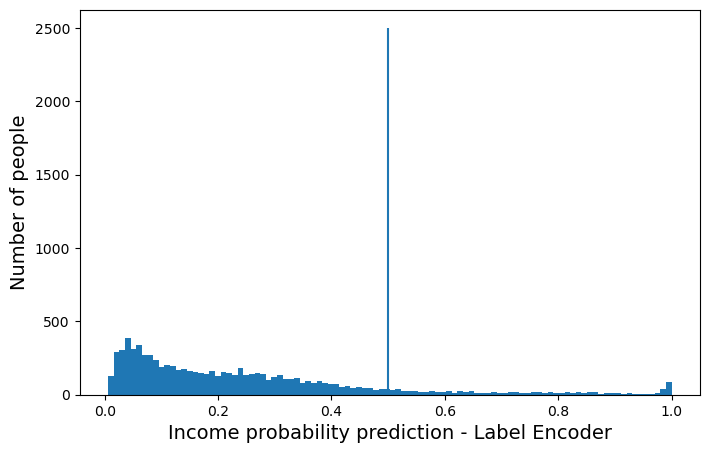

In [38]:
# Data encoded with Label Encoder

plt.figure(figsize = (8, 5))

plt.hist(pred_proba_le[:, 1], bins = 100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Income probability prediction - Label Encoder', fontsize = 14)
plt.ylabel('Number of people', fontsize = 14)

experiment.log_figure('Predicted_Income_Probability_LE', plt)

{'web': 'https://www.comet.com/api/image/download?imageId=0f49a2bf1e534e208f8ae6faeb825e31&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0f49a2bf1e534e208f8ae6faeb825e31&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'imageId': '0f49a2bf1e534e208f8ae6faeb825e31'}

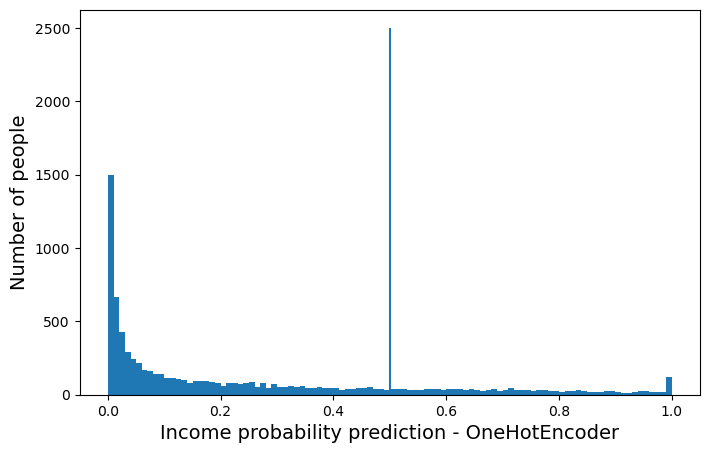

In [39]:
# Data encoded with OneHotEncoder

plt.figure(figsize = (8, 5))

plt.hist(pred_proba_oh[:, 1], bins = 100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Income probability prediction - OneHotEncoder', fontsize = 14)
plt.ylabel('Number of people', fontsize = 14)

experiment.log_figure('Predicted_Income_Probability_OHE', plt)

### ROC curve


Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [40]:
from sklearn.metrics import roc_curve

In [41]:
false_positive_rates_le, true_positive_rates_le, threshold_le = roc_curve(y_test, pred_proba_le[:, 1])

{'web': 'https://www.comet.com/api/image/download?imageId=4693112379d8428bb99846d1fd01a3b3&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=4693112379d8428bb99846d1fd01a3b3&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'imageId': '4693112379d8428bb99846d1fd01a3b3'}

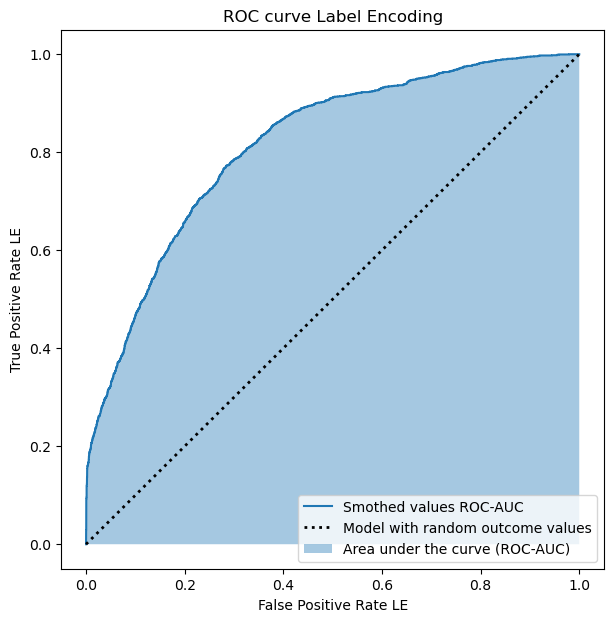

In [42]:
plt.figure(figsize = (7, 7))

plt.plot(false_positive_rates_le, true_positive_rates_le, label = 'Smothed values ROC-AUC')
plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = ':', label = 'Model with random outcome values')

plt.title('ROC curve Label Encoding')
plt.xlabel('False Positive Rate LE')
plt.ylabel('True Positive Rate LE')

plt.fill_between(false_positive_rates_le, true_positive_rates_le, step = 'pre', alpha = 0.4,
                label = 'Area under the curve (ROC-AUC)')

plt.legend();

experiment.log_figure('ROC_curve_LE', plt)

{'web': 'https://www.comet.com/api/image/download?imageId=831bc76efa644eb188d44fb85ad590a2&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=831bc76efa644eb188d44fb85ad590a2&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'imageId': '831bc76efa644eb188d44fb85ad590a2'}

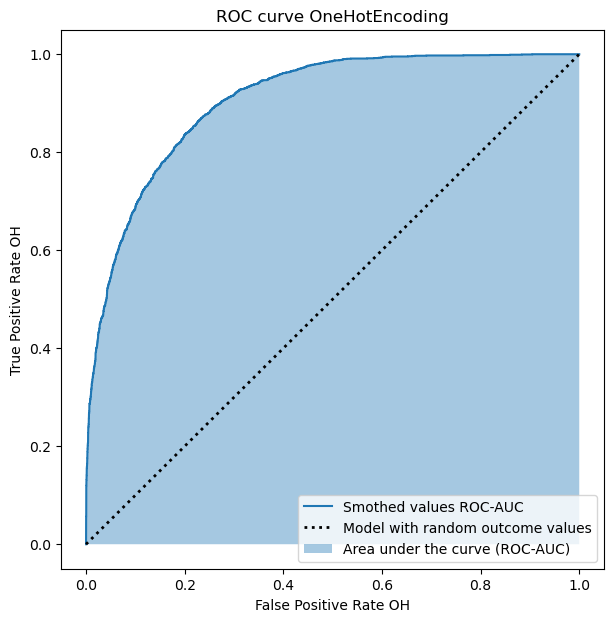

In [43]:
false_positive_rates_oh, true_positive_rates_oh, threshold_oh = roc_curve(y_test, pred_proba_oh[:, 1])

plt.figure(figsize = (7, 7))

plt.plot(false_positive_rates_oh, true_positive_rates_oh, label = 'Smothed values ROC-AUC')
plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = ':', label = 'Model with random outcome values')

plt.title('ROC curve OneHotEncoding')
plt.xlabel('False Positive Rate OH')
plt.ylabel('True Positive Rate OH')

plt.fill_between(false_positive_rates_oh, true_positive_rates_oh, step = 'pre', alpha = 0.4,
                label = 'Area under the curve (ROC-AUC)')

plt.legend();

experiment.log_figure('ROC_curve_OH', plt)

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_le = roc_auc_score(y_test, pred_proba_le[:, 1]).round(3)
print('ROC-AUC on Label Encoded Data', roc_auc_le)

experiment.log_metric('ROC-AUC LE', roc_auc_le)

ROC-AUC on Label Encoded Data 0.815


In [46]:
roc_auc_oh = roc_auc_score(y_test, pred_proba_oh[:, 1]).round(3)
print('ROC-AUC on OneHotEncoded Data', roc_auc_oh)

experiment.log_metric('ROC-AUC OHE', roc_auc_oh)

ROC-AUC on OneHotEncoded Data 0.906


## <center> Modeling on dataset encoded with multi encoders simultanoiusly and removed outliers </center>

> Since the number of unique characters in categorical features is varied from 2 to 42, let's try to encoded each of the feature with corresponding encoder.

In [47]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_enc = ['sex', 'race', 'relationship', 'workclass', 'marital-status']
binary_enc = ['native-country']
ohe_enc = ['education', 'occupation']

X_train_encoded.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States
1,27,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States
2,44,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States


In [48]:
label_encoder = LabelEncoder()

for feature in label_enc:
    X_train_encoded[feature] = label_encoder.fit_transform(X_train_encoded[feature])
    X_test_encoded[feature] = label_encoder.fit_transform(X_test_encoded[feature])

X_train_encoded.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,HS-grad,2,Craft-repair,0,4,1,0.0,0.0,40,United-States
1,27,4,HS-grad,2,Machine-op-inspct,0,4,1,0.0,0.0,45,United-States
2,44,4,11th,2,Other-service,0,2,1,0.0,0.0,60,United-States
3,59,4,Bachelors,5,Adm-clerical,4,4,1,0.0,0.0,60,United-States
4,54,4,Bachelors,0,Sales,1,4,0,0.0,1408.0,38,United-States


In [49]:
onehot_encoder = OneHotEncoder()

X_train_encoded_oh = onehot_encoder.fit_transform(X_train_encoded[ohe_enc]).toarray()
X_test_encoded_oh = onehot_encoder.fit_transform(X_test_encoded[ohe_enc]).toarray()

columns_oh = onehot_encoder.get_feature_names_out(ohe_enc)

X_train_encoded_oh = pd.DataFrame(X_train_encoded_oh, columns = columns_oh)
X_test_encoded_oh = pd.DataFrame(X_test_encoded_oh, columns = columns_oh)

X_train_encoded_1 = pd.concat([X_train_encoded, X_train_encoded_oh], axis = 1)
X_test_encoded_1 = pd.concat([X_test_encoded, X_test_encoded_oh], axis = 1)

X_train_encoded_1 = X_train_encoded_1.drop(columns = ohe_enc)
X_test_encoded_1 = X_test_encoded_1.drop(columns = ohe_enc)

X_train_encoded_1.head()

,age,workclass,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,49,4,2,0,4,1,0.0,0.0,40,United-States,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27,4,2,0,4,1,0.0,0.0,45,United-States,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44,4,2,0,2,1,0.0,0.0,60,United-States,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,4,5,4,4,1,0.0,0.0,60,United-States,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54,4,0,1,4,0,0.0,1408.0,38,United-States,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [50]:
import category_encoders as ce

In [51]:
binar_encoder = ce.BinaryEncoder(cols = binary_enc)

X_train_encoded_be = binar_encoder.fit_transform(X_train_encoded_1[binary_enc])
X_test_encoded_be = binar_encoder.fit_transform(X_test_encoded_1[binary_enc])

X_train_encoded_final = pd.concat([X_train_encoded_1, X_train_encoded_be], axis = 1)
X_test_encoded_final = pd.concat([X_test_encoded_1, X_test_encoded_be], axis = 1)

X_train_encoded_final = X_train_encoded_final.drop(columns = binary_enc)
X_test_encoded_final = X_test_encoded_final.drop(columns = binary_enc)

X_train_encoded_final.head()

,age,workclass,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,native-country_0,native-country_1,native-country_2,native-country_3,native-country_4,native-country_5
0,49,4,2,0,4,1,0.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
1,27,4,2,0,4,1,0.0,0.0,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2,44,4,2,0,2,1,0.0,0.0,60,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
3,59,4,5,4,4,1,0.0,0.0,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
4,54,4,0,1,4,0,0.0,1408.0,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,1


> Identify and remove the outliers

In [52]:
y_train_final = y_train.copy()
y_test_final = y_test.copy()

In [53]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination = 0.1)
y_pred_train_encoded = iso.fit_predict(X_train_encoded_final)

mask_train_encoded = y_pred_train_encoded != -1
X_train_encoded_final, y_train_final = X_train_encoded_final[mask_train_encoded], y_train_final[mask_train_encoded]

print('Train data Multiple Encoders & w/o outliers', X_train_encoded_final.shape, y_train_final.shape)

Train data Multiple Encoders & w/o outliers (21978, 46) (21978,)


In [54]:
y_pred_test_encoded = iso.fit_predict(X_test_encoded_final)

mask_test_encoded = y_pred_test_encoded != -1
X_test_encoded_final, y_test_final = X_test_encoded_final[mask_test_encoded], y_test_final[mask_test_encoded]

print('Test data Multiple Encoders & w/o outliers', X_test_encoded_final.shape, y_test_final.shape)

Test data Multiple Encoders & w/o outliers (7327, 46) (7327,)


In [55]:
model = linear_model.LogisticRegression(random_state = 42, max_iter = 10000)
model.fit(X_train_encoded_final, y_train_final)

prediction = model.predict(X_test_encoded_final)

accuracy = accuracy_score(prediction, y_test_final)

experiment.log_metric('Accuracy Score Multiple Encoders, no outliers', accuracy)

print('Accuracy Score Multiple Encoders, no outliers: {:.3f}'.format(accuracy))

Accuracy Score Multiple Encoders, no outliers: 0.829


#### Conclusion:

The Accuracy metrics on multi encoded dataset is a bit lower compare to the accuracy recieved on the data-set encoded with OneHotEncoder only.
Let's see if we can improve the result by identifying and removing outliers on dataset encoded ONLY with OneHotEncoder

In [56]:
y_train_oh = y_train.copy()
y_test_oh = y_test.copy()

y_pred_train_oh = iso.fit_predict(X_train_oh)

mask_train_oh = y_pred_train_oh != -1
X_train_oh, y_train_oh = X_train_oh[mask_train_oh], y_train_oh[mask_train_oh]

print('Train data OneHotEncoded & w/o outliers', X_train_oh.shape, y_train_oh.shape)
print('\n')

y_pred_test_oh = iso.fit_predict(X_test_oh)

mask_test_oh = y_pred_test_oh != -1
X_test_oh, y_test_oh = X_test_oh[mask_test_oh], y_test_oh[mask_test_oh]

print('Test data OneHotEncoded & w/o outliers', X_test_oh.shape, y_test_oh.shape)

Train data OneHotEncoded & w/o outliers (21978, 106) (21978,)


Test data OneHotEncoded & w/o outliers (7327, 106) (7327,)


In [57]:
model = linear_model.LogisticRegression(random_state = 42, max_iter = 10000)
model.fit(X_train_oh, y_train_oh)

prediction = model.predict(X_test_oh)

accuracy = accuracy_score(prediction, y_test_oh)

experiment.log_metric('Accuracy Score OneHotEncoder, no outliers', accuracy)

print('Accuracy Score OneHotEncoder, no outliers: {:.3f}'.format(accuracy))

Accuracy Score OneHotEncoder, no outliers: 0.851


In [58]:
# Confusion matrix on dataset OneHotEncoded & no outliers

matrix = pd.DataFrame(confusion_matrix(y_test_oh, prediction))
print(matrix)

      0     1
0  5174   369
1   724  1060


In [59]:
experiment.log_confusion_matrix(y_test_oh, prediction)

{'web': 'https://www.comet.com/api/asset/download?assetId=edf29ecd60974085aecad3050c2ca3a7&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=edf29ecd60974085aecad3050c2ca3a7&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'assetId': 'edf29ecd60974085aecad3050c2ca3a7'}

{'web': 'https://www.comet.com/api/image/download?imageId=6cc61561621f4bdc8188953f03c6d278&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=6cc61561621f4bdc8188953f03c6d278&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'imageId': '6cc61561621f4bdc8188953f03c6d278'}

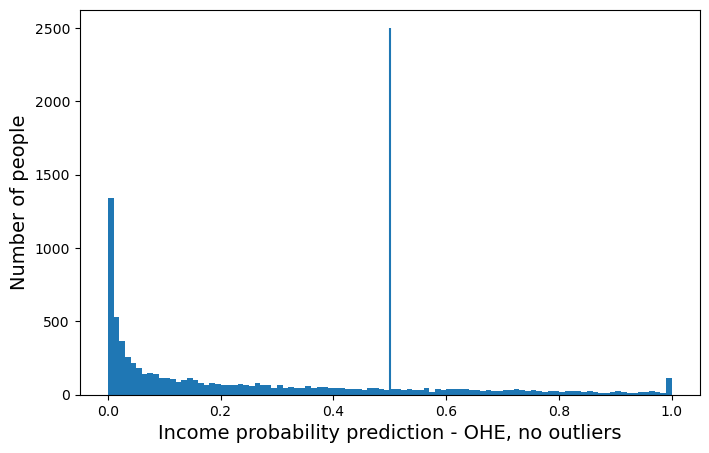

In [60]:
pred_proba = model.predict_proba(X_test_oh)

plt.figure(figsize = (8, 5))

plt.hist(pred_proba[:, 1], bins = 100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Income probability prediction - OHE, no outliers', fontsize = 14)
plt.ylabel('Number of people', fontsize = 14)

experiment.log_figure('Predicted_Income_Probability_OHE, no outliers', plt)

In [61]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test_oh, pred_proba[:, 1])

{'web': 'https://www.comet.com/api/image/download?imageId=23ebdfae119940cb82071cea782c85f6&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=23ebdfae119940cb82071cea782c85f6&experimentKey=cf510b42ea4a4c1f8f4e7dcffd30fc96',
 'imageId': '23ebdfae119940cb82071cea782c85f6'}

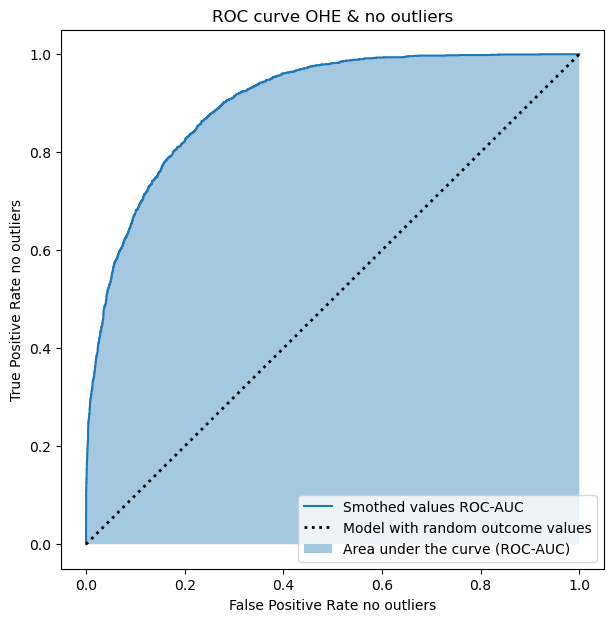

In [62]:
plt.figure(figsize = (7, 7))

plt.plot(false_positive_rates, true_positive_rates, label = 'Smothed values ROC-AUC')
plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = ':', label = 'Model with random outcome values')

plt.title('ROC curve OHE & no outliers')
plt.xlabel('False Positive Rate no outliers')
plt.ylabel('True Positive Rate no outliers')

plt.fill_between(false_positive_rates, true_positive_rates, step = 'pre', alpha = 0.4,
                label = 'Area under the curve (ROC-AUC)')

plt.legend();

experiment.log_figure('ROC_curve_outliers', plt)

In [64]:
roc_auc = roc_auc_score(y_test_oh, pred_proba[:, 1]).round(3)
print('ROC-AUC on OHE, no outliers', roc_auc)

experiment.log_metric('ROC-AUC OHE, no outliers', roc_auc)

ROC-AUC on OHE, no outliers 0.903


### Conclusion:

Logistic Regression model shows the best result on the dataset encoded with OneHotEncoder library sklearn, without deleting data, that algorithm Isolation Forest considered as outliers.

Further actions that can be done:

1. Review the outliers with LocalOutlierFactor;

2. See the results achieved with Tukey or Z-method outliers;

3. Encoded dataset with combination of OneHotEncoder and Label Encoder only.

In [65]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nataliamantyk/us-citizens-income-prediction-model/cf510b42ea4a4c1f8f4e7dcffd30fc96
COMET INFO:   Metrics:
COMET INFO:     Accuracy Label Encoding Data                  : 0.8021127625598821
COMET INFO:     Accuracy One Hot Encoding Data                : 0.8556688367522417
COMET INFO:     Accuracy Score Multiple Encoders, no outliers : 0.8293981165552068
COMET INFO:     Accuracy Score OneHotEncoder, no outliers     : 0.8508257131158729
COMET INFO:     ROC-AUC LE                                    : 0.815
COMET INFO:     ROC-AUC OHE                                   : 0.906
COMET INFO:     ROC-AUC OHE, no outliers                  